In [1]:
import sys, os, glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.stats import percentileofscore
from sw_plotting import plot_cum_dist, plot_dist
from sw_plotting import plot_track_distance_to_surface

# make a folder to store figures if not already there
!mkdir ../jupyter_figures

mkdir: ../jupyter_figures: File exists


In [2]:
data_folder = '../data/imaris-overall-tracking-data/Tracks-surface-proximal/'
track_file = data_folder + '2020-01-25-K14R-HisG-2photon-25x-2-denoised_Shortest_Distance_to_Surfaces_Surfaces=Surfaces_1.csv'
output_prefix = '2020-01-25-K14R-HisG-2photon-25x-2-denoised-surface-proximal-tracks'
df = pd.read_csv(track_file, skiprows=3)
df.rename(columns={'Shortest Distance to Surfaces':'Distance'}, inplace=True)
df.head()


,Distance,Unit,Category,Surfaces,Time,TrackID,ID,Unnamed: 7
0,-3.79688,um,Spot,Surfaces 1,25,1000000000,0,NaN
1,-6.42798,um,Spot,Surfaces 1,25,1000000001,1,NaN
2,-6.48458,um,Spot,Surfaces 1,25,1000000002,2,NaN
3,-7.88086,um,Spot,Surfaces 1,25,1000000003,3,NaN
4,-7.83211,um,Spot,Surfaces 1,25,1000000004,4,NaN


In [3]:
filtered_file = data_folder + output_prefix + '-filtered.csv'

if os.path.isfile(filtered_file):
    df_filtered = pd.read_csv(filtered_file)

else:
    # Filter out tracks that go outside of the surface
    # These tracks are mesenchyme tracks closely delineating the surface
    # that got selected when the simple minimal distance criteria was used
    # to filter tracks in Imaris

    tracks_to_drop = []
    for track in df.TrackID.unique():
        df_temp = df[df.TrackID==track]
        track_max_dist_temp = np.max(df_temp.Distance)
        if track_max_dist_temp >= 0:
            tracks_to_drop.append(track)
    print("Total number of tracks to drop: ", len(tracks_to_drop))

    df_filtered = df[~df.TrackID.isin(tracks_to_drop)]

    # save the file to speed up future processing
    df_filtered.to_csv(filtered_file, index=False)
    

In [4]:
print("Total number of tracks before filtering: ", df.TrackID.nunique())
print("Total number of spots before filtering: ", len(df))
print("Total number of tracks after filtering: ", df_filtered.TrackID.nunique())
print("Total number of spots after filtering: ", len(df_filtered))

Total number of tracks before filtering:  14867
Total number of spots before filtering:  392672
Total number of tracks after filtering:  14808
Total number of spots after filtering:  389899


In [5]:
# # output_file_name = '../jupyter_figures/' + output_prefix + '-CDF-spot-distance-to-surface.svg'
# output_file_name = None
# plot_cum_dist(df_filtered.Distance, output_fig_path=output_file_name, n_bins=20,
#               x_max=0, x_ticks=[-45, -30, -15, 0], y_ticks=[0.0, 0.5, 1.0])


In [6]:
# Find the corresponding percentile of specified value
percentileofscore(df_filtered.Distance, -15)


23.774233840045756

In [7]:
df_filtered.head()

,Distance,Unit,Category,Surfaces,Time,TrackID,ID,Unnamed: 7
0,-3.79688,um,Spot,Surfaces 1,25,1000000000,0,NaN
1,-6.42798,um,Spot,Surfaces 1,25,1000000001,1,NaN
2,-6.48458,um,Spot,Surfaces 1,25,1000000002,2,NaN
3,-7.88086,um,Spot,Surfaces 1,25,1000000003,3,NaN
4,-7.83211,um,Spot,Surfaces 1,25,1000000004,4,NaN


In [8]:
# Data wrangling to get an array of tracks for heatmap plotting

tracks = df.TrackID.unique()

N_tracks = 500 # Total number tracks to plot
N_points = 100 # Normalize the umber of points per track by linear interpolation
track_count = 0 # counter to stop when enough tracks retrieved

# the random seed to choose tracks, use for reproducibile appearance of plot
rand_seed = 2
np.random.seed(rand_seed)

# the "*100" is to make sure getting enough tracks with the selection criteria
surface_track_distances = []
for i in np.random.randint(0, len(tracks), N_tracks*100):
    # Get the data frame subset of current track
    df_temp = df[ df.TrackID==tracks[i] ]
    # Filter out short tracks
    if len(df_temp)<36:
        continue
    # Filter out very long tracks that tends to contain errors
    if len(df_temp)>120:
        continue

    # Filter out tracks with positive distance,
    # which are likely outside of the epithelial surface
    if pd.Series(df_temp.Distance>-3).any():
        continue
    
    # interpolate the x, y coordinates with defined number of values
    yOld = df_temp.Distance.tolist()
    xOld = np.arange(0, len(yOld))
    xNew = np.linspace(0, len(yOld)-1, N_points)
    f1 = interp1d(xOld, yOld)
    yNew = f1(xNew)
    surface_track_distances.append(yNew)
    
    track_count += 1
    if track_count > N_tracks:
        break

# Check whether desired number of plot were obtained
assert track_count == N_tracks + 1

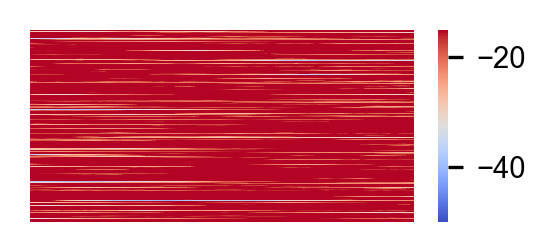

In [9]:
# make horizontal figure without sorting

fig_width, fig_height = 2, .8
fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

sns.heatmap(list(reversed(surface_track_distances)),
#             cmap=sns.light_palette("#5555ff", n_colors=100),
            cmap='coolwarm',
            vmin=-50, vmax=-15)

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

plt.axis("off")

outputFigPath = '../jupyter_figures/'+output_prefix+'-surface-track-heatmap-sorted-coolwarm-horizontal-no-sorting-seed'+str(rand_seed)+'.png'
plt.savefig(outputFigPath)
